# Examine Tactus alcohol diaries

In [35]:
import datetime
import gzip
import re
import sys
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
DIRECTORY = "/home/erikt/projects/e-mental-health/usb/tmp/20190917/"
DIARYENTRYTAG = "./Diary/DiaryEntries/DiaryEntry"
DATE = "./Date"
STANDARDUNITS = "./StandardUnits"

Read all the available data from the alcohol diaries.

In [3]:
data = {}
for client in range(1,1988):
    clear_output(wait=True)
    print(client)
    try:
        inFileName = "AdB"+str(client).zfill(4)+".xml.gz"
        inFile = gzip.open(DIRECTORY+inFileName,"rb")
        text = inFile.read()
        inFile.close()
    except: continue
    clientId = inFileName.split(".")[0]
    root = ET.fromstring(text)
    for diaryEntry in root.findall(DIARYENTRYTAG):
        date = diaryEntry.findall(DATE)[0].text.strip()
        standardUnits = diaryEntry.findall(STANDARDUNITS)[0].text.strip()
        standardUnits = re.sub(",",".",standardUnits)
        if not clientId in data: data[clientId] = {}
        if date in data[clientId]: data[clientId][date] += float(standardUnits)
        else: data[clientId][date] = float(standardUnits)

Convert the daily diary data to running totals of the past seven days. Normalize the dates with respect to the first available date of each client. 

In [4]:
WEEKLEN = 7

def makeWeekData(data):
    weekData = {}
    for clientId in data:
        weekData[clientId] = {}
        dates = sorted(data[clientId].keys())
        date0 = datetime.datetime.strptime(dates[0],"%Y-%m-%d")
        for i in range(0,len(dates)):
            date1 = datetime.datetime.strptime(dates[i],"%Y-%m-%d")
            weekData[clientId][(date1-date0).days] = data[clientId][dates[i]]
            oneWeekAgo = date1+datetime.timedelta(days=-WEEKLEN)
            for j in range(1,WEEKLEN):
                if i-j >= 0:
                    date2 = datetime.datetime.strptime(dates[i-j],"%Y-%m-%d")
                    if date2 > oneWeekAgo:
                        weekData[clientId][(date1-date0).days] += data[clientId][dates[i-j]]
    return(weekData)
    
weekData = makeWeekData(data)

Remove the data for clients which have diary data available for more than two years as these would dominate the graphs and make the other data less visible.

In [5]:
DAYSPERYEAR = 365

toBeDeleted = []
for clientId in weekData:
    for days in weekData[clientId]:
        if days > 2*DAYSPERYEAR: 
            print(clientId)
            toBeDeleted.append(clientId)
            break
for clientId in toBeDeleted: del(weekData[clientId])

AdB0584
AdB0787
AdB1632


Plot all data.

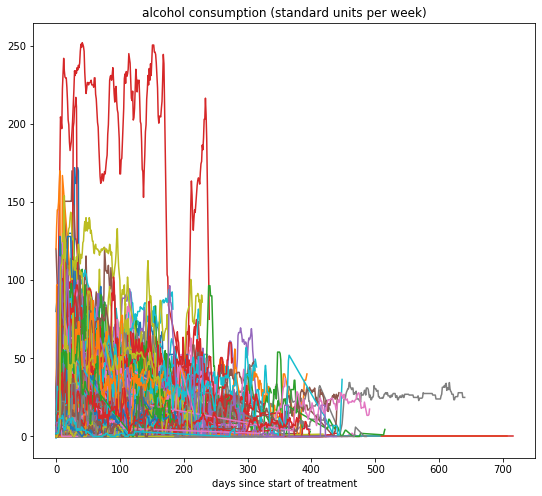

In [6]:
plt.figure(figsize=(9,8))
for clientId in weekData:
    plt.plot(list(weekData[clientId].keys()),list(weekData[clientId].values()),label=clientId)
plt.xlabel("days since start of treatment")
dummy = plt.title("alcohol consumption (standard units per week)")

Read information about dropouts and completers.

In [7]:
import csv
import gzip

DIRDROPOUT = "/home/erikt/projects/e-mental-health/usb/releases/20200305/"
FILEDROPOUT = "selected.csv.gz"
DELIMITER = ","
FIELDNAMEDROPOUT = "dropout"
FIELDNAMEFILE = "file"
NBROFCLIENTS = 791
CODEDROPOUT = "1"
CODECOMPLETER = "2"
DROPOUT = "dropout"
COMPLETER = "completer"

dropout = {}
inFile = gzip.open(DIRDROPOUT+FILEDROPOUT,"rt",encoding="utf-8")
csvreader = csv.DictReader(inFile,delimiter=DELIMITER)
for row in csvreader: dropout[row[FIELDNAMEFILE]] = row[FIELDNAMEDROPOUT]
inFile.close()

len([x for x in dropout if dropout[x] != "?"]) == NBROFCLIENTS

True

Select the consumption information for dropouts and completers.

In [8]:
CODEDROPOUT = "1"
CODECOMPLETER = "2"
DROPOUT = "dropout"
COMPLETER = "completer"
TOTAL = "total"
COUNT = "count"

consumptionDropout = {DROPOUT:{TOTAL:{},COUNT:{}},COMPLETER:{TOTAL:{},COUNT:{}}}
for clientId in dropout:
    if dropout[clientId] == CODEDROPOUT and clientId in weekData:
        for days in weekData[clientId]:
            if not days in consumptionDropout[DROPOUT][TOTAL]:
                consumptionDropout[DROPOUT][TOTAL][days] = 0
                consumptionDropout[DROPOUT][COUNT][days] = 0
            consumptionDropout[DROPOUT][TOTAL][days] += weekData[clientId][days]
            consumptionDropout[DROPOUT][COUNT][days] += 1
    if dropout[clientId] == CODECOMPLETER and clientId in weekData:
        for days in weekData[clientId]:
            if not days in consumptionDropout[COMPLETER][TOTAL]:
                consumptionDropout[COMPLETER][TOTAL][days] = 0
                consumptionDropout[COMPLETER][COUNT][days] = 0
            consumptionDropout[COMPLETER][TOTAL][days] += weekData[clientId][days]
            consumptionDropout[COMPLETER][COUNT][days] += 1

Separately plot dropouts.

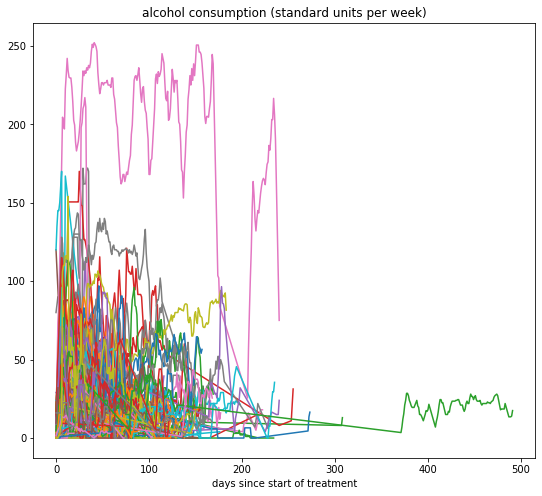

In [9]:
plt.figure(figsize=(9,8))
for clientId in weekData:
    if clientId in dropout and dropout[clientId] == CODEDROPOUT:
        plt.plot(list(weekData[clientId].keys()),list(weekData[clientId].values()),label=clientId)
plt.xlabel("days since start of treatment")
dummy = plt.title("alcohol consumption (standard units per week)")

Separately plot completers.

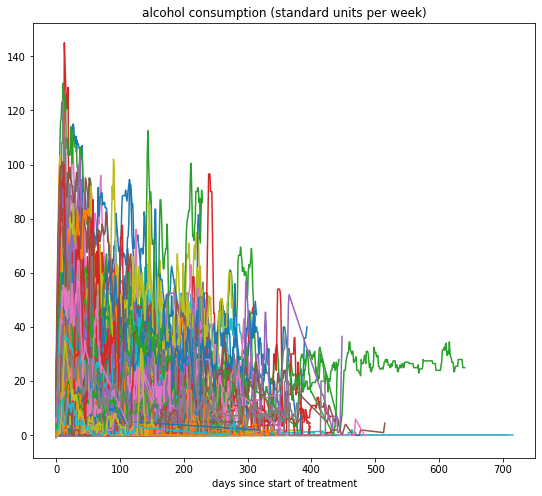

In [10]:
plt.figure(figsize=(9,8))
for clientId in weekData:
    if clientId in dropout and dropout[clientId] == CODECOMPLETER:
        plt.plot(list(weekData[clientId].keys()),list(weekData[clientId].values()),label=clientId)
plt.xlabel("days since start of treatment")
dummy = plt.title("alcohol consumption (standard units per week)")

Plot the average consumption of dropouts and completers.

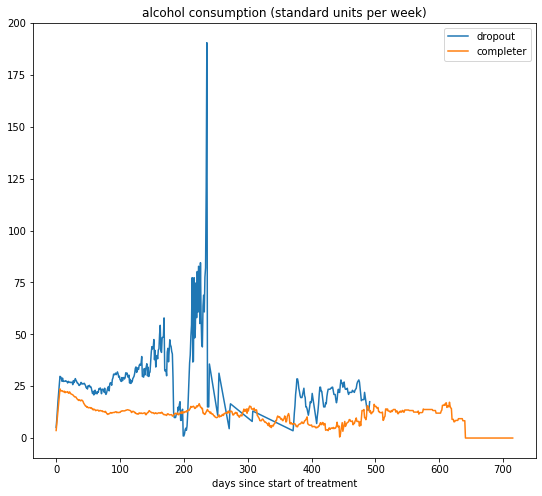

In [11]:
plt.figure(figsize=(9,8))
ax2 = plt.subplot(111)
x = list(sorted(consumptionDropout[DROPOUT][TOTAL].keys()))
y = [ consumptionDropout[DROPOUT][TOTAL][days]/consumptionDropout[DROPOUT][COUNT][days] for days in sorted(list(consumptionDropout[DROPOUT][TOTAL].keys())) ]
ax2.plot(x,y,label=DROPOUT)
x = list(sorted(consumptionDropout[COMPLETER][TOTAL].keys()))
y = [ consumptionDropout[COMPLETER][TOTAL][days]/consumptionDropout[COMPLETER][COUNT][days] for days in sorted(list(consumptionDropout[COMPLETER][TOTAL].keys())) ]
ax2.plot(x,y,label=COMPLETER)
plt.xlabel("days since start of treatment")
plt.legend()
dummy = plt.title("alcohol consumption (standard units per week)")

Plot the numbers of the first 100 days

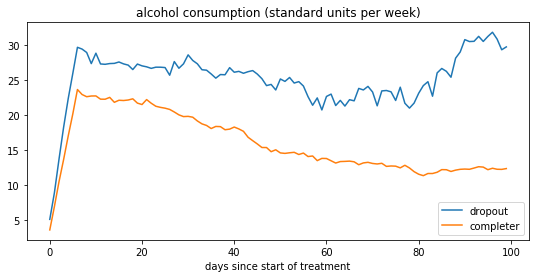

In [14]:
N = 100

plt.figure(figsize=(9,4))
ax2 = plt.subplot(111)
x = list(sorted(consumptionDropout[DROPOUT][TOTAL].keys()))
y = [ consumptionDropout[DROPOUT][TOTAL][days]/consumptionDropout[DROPOUT][COUNT][days] for days in sorted(list(consumptionDropout[DROPOUT][TOTAL].keys())) ]
ax2.plot(x[0:N],y[0:N],label=DROPOUT)
x = list(sorted(consumptionDropout[COMPLETER][TOTAL].keys()))
y = [ consumptionDropout[COMPLETER][TOTAL][days]/consumptionDropout[COMPLETER][COUNT][days] for days in sorted(list(consumptionDropout[COMPLETER][TOTAL].keys())) ]
ax2.plot(x[0:N],y[0:N],label=COMPLETER)
plt.xlabel("days since start of treatment")
plt.legend()
dummy = plt.title("alcohol consumption (standard units per week)")

Count the number of dropouts and completers contributing to the consumption data.

In [20]:
consumptionDropout[DROPOUT][COUNT][0],consumptionDropout[COMPLETER][COUNT][0]

(379, 350)

Compare the consumption numbers of the first week.

In [37]:
FIRSTWEEK = 6
firstWeekDropouts = {clientId:weekData[clientId][FIRSTWEEK] for clientId in weekData if FIRSTWEEK in weekData[clientId] and \
                                                                                       clientId in dropout and \
                                                                                       dropout[clientId] == CODEDROPOUT}
firstWeekCompleters = {clientId:weekData[clientId][FIRSTWEEK] for clientId in weekData if FIRSTWEEK in weekData[clientId] and \
                                                                                          clientId in dropout and \
                                                                                          dropout[clientId] == CODECOMPLETER}

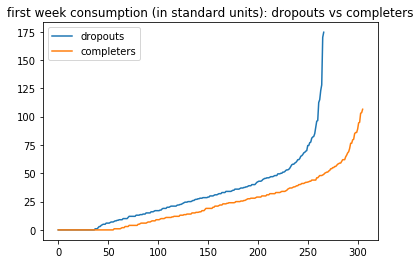

In [38]:
plt.plot(range(0,len(firstWeekDropouts)),sorted(firstWeekDropouts.values()),label="dropouts")
plt.plot(range(0,len(firstWeekCompleters)),sorted(firstWeekCompleters.values()),label="completers")
plt.legend()
plt.title("first week consumption (in standard units): dropouts vs completers")
plt.show()

Dropouts consume more alcohol in the first week of the treatment than completers. 

What do we see when we combine the first week alcohol consumption with the lengths of the first four client mails?

In [20]:
textLengthsDropout = pd.read_csv("dropout-text-lengths.csv",index_col="id").to_dict()["value"]
textLengthsCompleter = pd.read_csv("completer-text-lengths.csv",index_col="id").to_dict()["value"]

In [59]:
plotDataDropout = [(firstWeekDropouts[clientId],textLengthsDropout[clientId]) for clientId in firstWeekDropouts if clientId in textLengthsDropout]
plotDataCompleter = [(firstWeekCompleters[clientId],textLengthsCompleter[clientId]) for clientId in firstWeekCompleters if clientId in textLengthsCompleter]

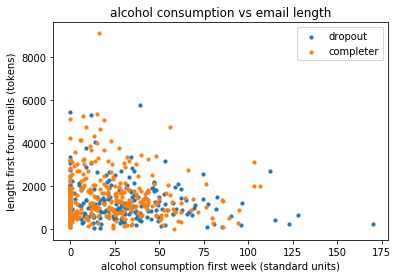

In [65]:
plt.scatter([x[0] for x in plotDataDropout],[x[1] for x in plotDataDropout],label=DROPOUT,s=10)
plt.scatter([x[0] for x in plotDataCompleter],[x[1] for x in plotDataCompleter],label=COMPLETER,s=10)
plt.legend()
plt.xlabel("alcohol consumption first week (standard units)")
plt.ylabel("length first four emails (tokens)")
plt.title("alcohol consumption vs email length")
plt.show()

The two data sets seem inseperable based on these two criteria. It is possible to find identify a decent number of completers (43) at an precision of 78% (see below). But catually we are interested in identifying dropouts and that is more difficult wuith this data.

In [87]:
def thresholdTest(dict1,dict2,threshold):
    exceedsThreshold1 = len([x for x in dict1.values() if x > threshold])
    exceedsThreshold2 = len([x for x in dict2.values() if x > threshold])
    return(exceedsThreshold1/(exceedsThreshold1+exceedsThreshold2),exceedsThreshold1)

thresholdTest(textLengthsCompleter,textLengthsDropout,3000)
# thresholdTest(firstWeekDropouts,firstWeekCompleters,100)

(0.7818181818181819, 43)

What are the consumption levels at day 100?

In [89]:
DAY = 100
testDayDropouts = {clientId:weekData[clientId][DAY] for clientId in weekData if DAY in weekData[clientId] and \
                                                                                      clientId in dropout and \
                                                                                      dropout[clientId] == CODEDROPOUT}
testDayCompleters = {clientId:weekData[clientId][DAY] for clientId in weekData if DAY in weekData[clientId] and \
                                                                                        clientId in dropout and \
                                                                                        dropout[clientId] == CODECOMPLETER}

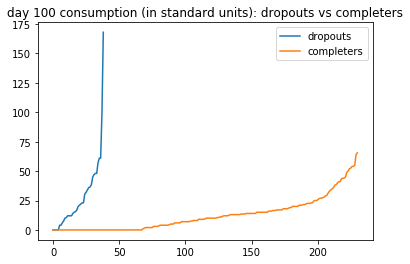

In [90]:
plt.plot(range(0,len(testDayDropouts)),sorted(testDayDropouts.values()),label="dropouts")
plt.plot(range(0,len(testDayCompleters)),sorted(testDayCompleters.values()),label="completers")
plt.legend()
plt.title("day 100 consumption (in standard units): dropouts vs completers")
plt.show()

## Alternative success criterium

We only consider clients with an average consumption of 3.0 or more standard units per day in the first week. We examine various succcess definitions:

1. average consumption lower than 3.0 for a whole week anywhere and as a faliure the others  
2. minimum consumption in a week is 50% of first week or less
3. minimum consumption in a week is 10% of first week or less

If a client stops with keeping track of the alcohol diary and restarts later, the week total be incorrect in the first six days from the restart.

In [52]:
THRESHOLD = 3.0
WEEKLENGTH = 7
FIRSTWEEK = WEEKLENGTH-1
SUCCESS = "success"
WEEK1 = "firstweek"
FRACTION = "fraction"

success = {}
for clientId in weekData:
    if FIRSTWEEK in weekData[clientId] and weekData[clientId][FIRSTWEEK] >= WEEKLENGTH*THRESHOLD:
        positiveResult = False
        previouslySeen = 0
        lastSeen = -2
        lowestFraction = 1.0
        for i in weekData[clientId].keys():
            if i-1 == lastSeen:
                previouslySeen += 1
                while previouslySeen > WEEKLEN: previouslySeen -= 1
            else:
                previouslySeen = 1
            if weekData[clientId][i] <= 0.1*weekData[clientId][FIRSTWEEK]:
                positiveResult = True
            if weekData[clientId][i]/weekData[clientId][FIRSTWEEK] < lowestFraction:
                lowestFraction = weekData[clientId][i]/weekData[clientId][FIRSTWEEK]
            lastSeen = i
        success[clientId] = {SUCCESS:positiveResult,WEEK1:weekData[clientId][FIRSTWEEK],FRACTION:lowestFraction}

In [58]:
textLengths = pd.read_csv("text-lengths.csv",index_col="id").to_dict()["value"]

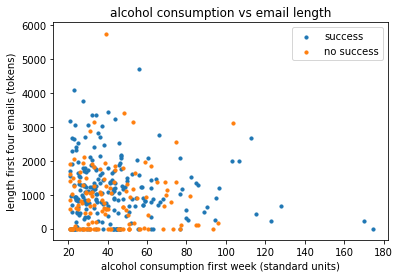

In [59]:
x1 = [success[c][WEEK1] for c in success if success[c][SUCCESS] and c in textLengths.keys()]
y1 = [textLengths[c] for c in success if success[c][SUCCESS] and c in textLengths.keys()]
z1 = [success[c][FRACTION] for c in success if success[c][SUCCESS] and c in textLengths.keys()]
plt.scatter(x1,y1,label=SUCCESS,s=10)
x2 = [success[c][WEEK1] for c in success if not success[c][SUCCESS] and c in textLengths.keys()]
y2 = [textLengths[c] for c in success if not success[c][SUCCESS] and c in textLengths.keys()]
z2 = [success[c][FRACTION] for c in success if not success[c][SUCCESS] and c in textLengths.keys()]
plt.scatter(x2,y2,label="no "+SUCCESS,s=10)
plt.legend()
plt.xlabel("alcohol consumption first week (standard units)")
plt.ylabel("length first four emails (tokens)")
plt.title("alcohol consumption vs email length")
plt.show()

In [60]:
np.corrcoef(x1,y1)[1][0],np.corrcoef(x2,y2)[1][0]

(-0.11682448710191083, 0.005937789824723314)

In [61]:
len(weekData),len(x1),len(x2)

(1241, 221, 129)